In [20]:
# Cell 1: Imports and Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set base path
BASE_PATH = r"d:\ecommerce-product-classifier\dataset"

In [21]:
BASE_PATH

'd:\\ecommerce-product-classifier\\dataset'

### 1. ENHANCED DATA SCANNING WITH IMAGE METADATA

In [22]:
# Cell 2: Quick Dataset Scan
def quick_scan():
    """Quick scan to understand dataset structure"""
    data = []
    
    for split in ['train', 'val', 'check']:
        split_path = os.path.join(BASE_PATH, split)
        if not os.path.exists(split_path):
            continue
            
        categories = os.listdir(split_path)
        for category in categories:
            category_path = os.path.join(split_path, category)
            if os.path.isdir(category_path):
                files = os.listdir(category_path)
                image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.bmp', '.gif'))]
                
                for img_file in image_files:
                    img_path = os.path.join(category_path, img_file)
                    data.append({
                        "split": split,
                        "category": category,
                        "filename": img_file,
                        "path": img_path
                    })
    
    return pd.DataFrame(data)

# Run quick scan
print("🚀 Starting quick dataset scan...")
df_quick = quick_scan()
print(f"✅ Quick scan complete: {len(df_quick):,} images found")

# Show basic statistics
print("\n📈 BASIC DATASET STATISTICS:")
print("="*60)
print(f"Total images: {len(df_quick):,}")
print(f"\nSplit distribution:")
split_counts = df_quick['split'].value_counts()
for split, count in split_counts.items():
    percentage = (count / len(df_quick)) * 100
    print(f"  {split}: {count:,} images ({percentage:.1f}%)")

print(f"\nCategory distribution (overall):")
category_counts = df_quick['category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(df_quick)) * 100
    print(f"  {category}: {count:,} images ({percentage:.1f}%)")

🚀 Starting quick dataset scan...
✅ Quick scan complete: 18,175 images found

📈 BASIC DATASET STATISTICS:
Total images: 18,175

Split distribution:
  train: 13,992 images (77.0%)
  val: 3,632 images (20.0%)
  check: 551 images (3.0%)

Category distribution (overall):
  GROCERY: 5,166 images (28.4%)
  HOME_KITCHEN_TOOLS: 2,228 images (12.3%)
  ELECTRONICS: 1,757 images (9.7%)
  PET_SUPPLIES: 1,637 images (9.0%)
  SPORTS_OUTDOOR: 1,605 images (8.8%)
  BEAUTY_HEALTH: 1,562 images (8.6%)
  HOBBY_ARTS_STATIONERY: 1,417 images (7.8%)
  BABY_PRODUCTS: 1,412 images (7.8%)
  CLOTHING_ACCESSORIES_JEWELLERY: 1,391 images (7.7%)


### SAMPLE AND ANALYZE IMAGES

In [23]:
# Cell 3: Sample Images for Detailed Analysis
def calculate_image_statistics(img):
    """Calculate comprehensive image statistics"""
    try:
        # Convert to RGB if necessary
        if img.mode != 'RGB':
            img_rgb = img.convert('RGB')
        else:
            img_rgb = img
        
        img_array = np.array(img_rgb)
        
        if len(img_array.shape) == 3:
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = img_array
        
        # Calculate metrics
        brightness = np.mean(gray)
        contrast = np.std(gray)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        return {
            'brightness': float(brightness),
            'contrast': float(contrast),
            'sharpness': float(sharpness)
        }
    except:
        return {'brightness': 0, 'contrast': 0, 'sharpness': 0}

print("\n🔍 Sampling images for detailed analysis...")
print("="*60)

sampled_data = []
for split in df_quick['split'].unique():
    split_df = df_quick[df_quick['split'] == split]
    for category in split_df['category'].unique():
        category_df = split_df[split_df['category'] == category]
        # Sample up to 10 images per category per split
        sample_size = min(10, len(category_df))
        sampled = category_df.sample(sample_size, random_state=42) if len(category_df) > sample_size else category_df
        
        for _, row in sampled.iterrows():
            img_path = row['path']
            try:
                with Image.open(img_path) as img:
                    img_stats = calculate_image_statistics(img)
                    
                    sampled_data.append({
                        "split": split,
                        "category": row['category'],
                        "filename": row['filename'],
                        "width": img.width,
                        "height": img.height,
                        "aspect_ratio": img.width / img.height if img.height > 0 else 0,
                        "file_size_kb": os.path.getsize(img_path) / 1024,
                        **img_stats,
                        "is_portrait": img.height > img.width,
                        "is_landscape": img.width > img.height,
                        "pixels": img.width * img.height,
                        "megapixels": (img.width * img.height) / 1e6
                    })
            except Exception as e:
                continue

df_sample = pd.DataFrame(sampled_data)
print(f"✅ Detailed analysis sample: {len(df_sample):,} images")


🔍 Sampling images for detailed analysis...
✅ Detailed analysis sample: 270 images


###  BASIC VISUALIZATIONS


🎨 Creating basic visualizations...


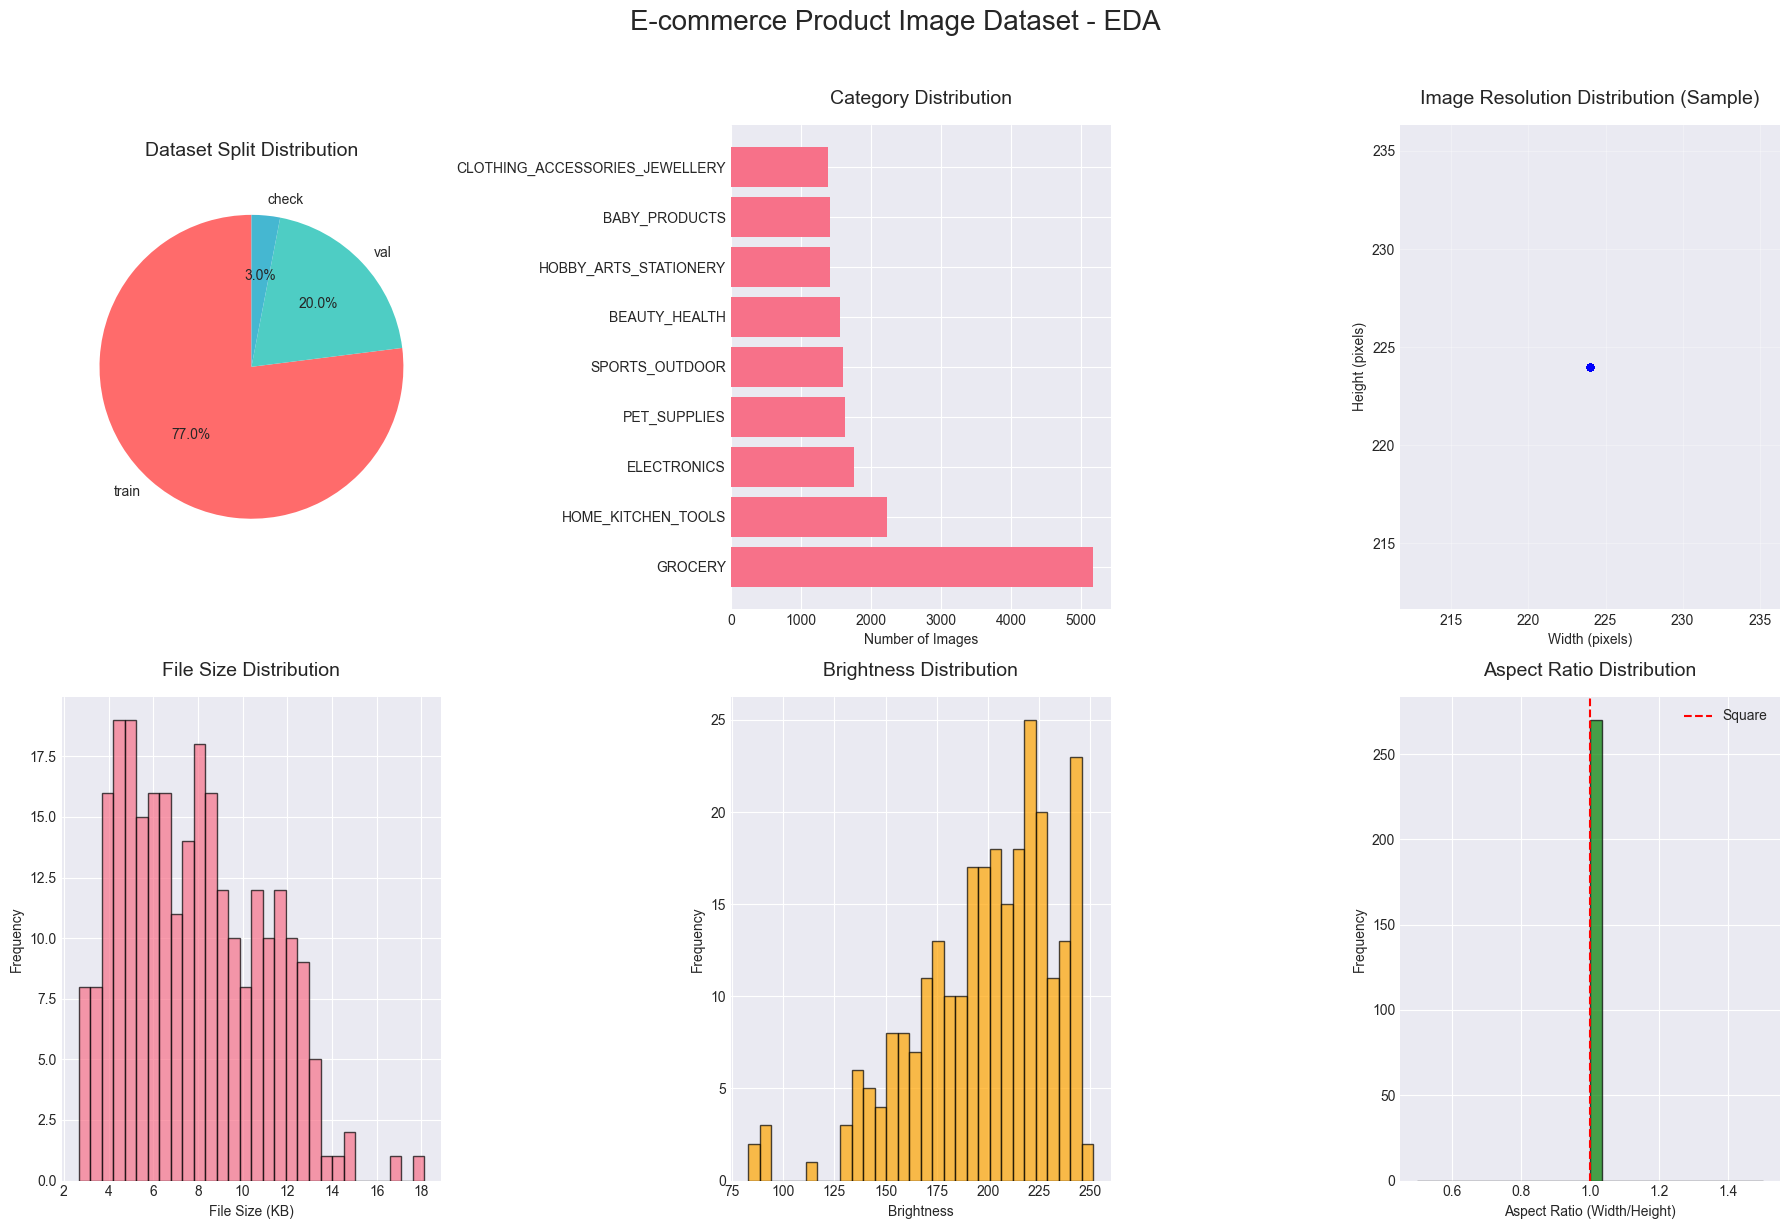

In [24]:
# Cell 4: Basic Visualizations
print("\n🎨 Creating basic visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('E-commerce Product Image Dataset - EDA', fontsize=20, y=1.02)

# 1. Split distribution
split_counts = df_quick['split'].value_counts()
axes[0, 0].pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%',
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[0, 0].set_title('Dataset Split Distribution', fontsize=14, pad=15)

# 2. Category distribution
category_counts = df_quick['category'].value_counts()
axes[0, 1].barh(range(len(category_counts)), category_counts.values)
axes[0, 1].set_yticks(range(len(category_counts)))
axes[0, 1].set_yticklabels(category_counts.index)
axes[0, 1].set_title('Category Distribution', fontsize=14, pad=15)
axes[0, 1].set_xlabel('Number of Images')

# 3. Image resolution scatter (from sample)
if len(df_sample) > 0:
    axes[0, 2].scatter(df_sample['width'], df_sample['height'], alpha=0.5, s=20, c='blue')
    axes[0, 2].set_title('Image Resolution Distribution (Sample)', fontsize=14, pad=15)
    axes[0, 2].set_xlabel('Width (pixels)')
    axes[0, 2].set_ylabel('Height (pixels)')
    axes[0, 2].grid(True, alpha=0.3)

# 4. File size distribution
if len(df_sample) > 0:
    axes[1, 0].hist(df_sample['file_size_kb'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('File Size Distribution', fontsize=14, pad=15)
    axes[1, 0].set_xlabel('File Size (KB)')
    axes[1, 0].set_ylabel('Frequency')

# 5. Brightness distribution
if len(df_sample) > 0:
    axes[1, 1].hist(df_sample['brightness'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].set_title('Brightness Distribution', fontsize=14, pad=15)
    axes[1, 1].set_xlabel('Brightness')
    axes[1, 1].set_ylabel('Frequency')

# 6. Aspect ratio distribution
if len(df_sample) > 0:
    axes[1, 2].hist(df_sample['aspect_ratio'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 2].set_title('Aspect Ratio Distribution', fontsize=14, pad=15)
    axes[1, 2].set_xlabel('Aspect Ratio (Width/Height)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].axvline(x=1, color='red', linestyle='--', label='Square')
    axes[1, 2].legend()

plt.tight_layout()
plt.show()

###  ADVANCED VISUALIZATIONS


📊 Creating advanced visualizations...


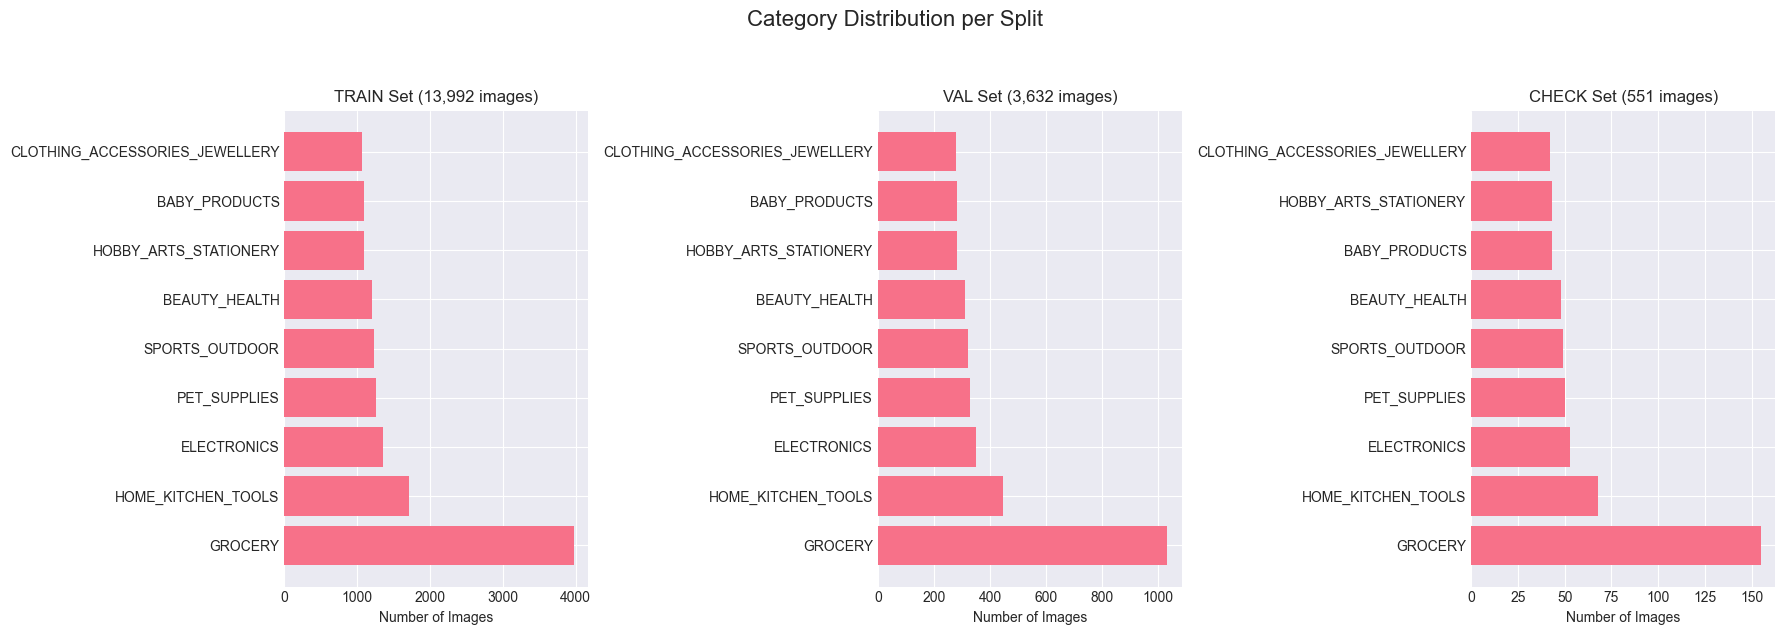

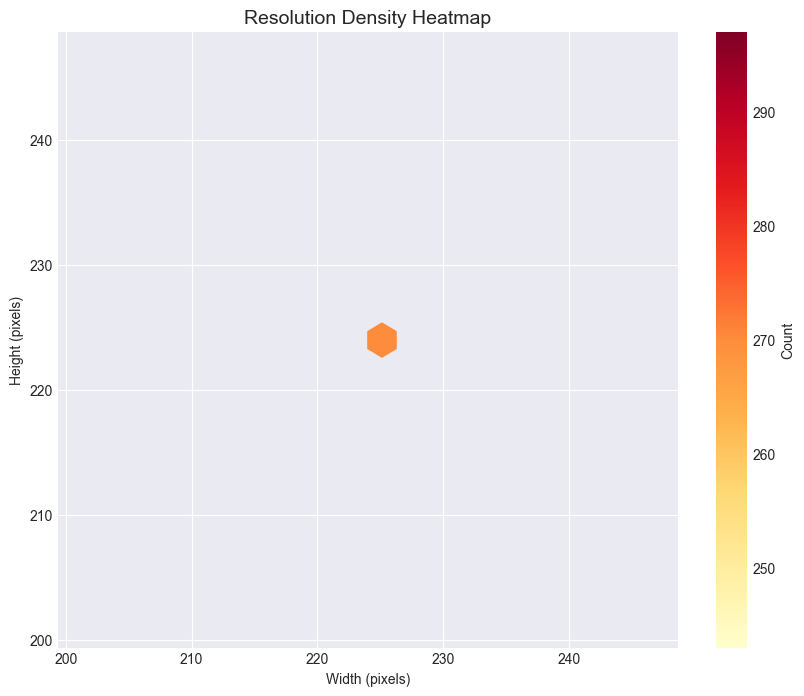

In [25]:
# Cell 5: Advanced Visualizations
print("\n📊 Creating advanced visualizations...")

# Split-wise category distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, split in enumerate(['train', 'val', 'check']):
    if split in df_quick['split'].values:
        split_df = df_quick[df_quick['split'] == split]
        cat_counts = split_df['category'].value_counts()
        axes[i].barh(range(len(cat_counts)), cat_counts.values)
        axes[i].set_yticks(range(len(cat_counts)))
        axes[i].set_yticklabels(cat_counts.index)
        axes[i].set_title(f'{split.upper()} Set ({len(split_df):,} images)', fontsize=12)
        axes[i].set_xlabel('Number of Images')

plt.suptitle('Category Distribution per Split', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Resolution heatmap
if len(df_sample) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    hexbin = ax.hexbin(df_sample['width'], df_sample['height'], gridsize=20, cmap='YlOrRd', mincnt=1)
    ax.set_title('Resolution Density Heatmap', fontsize=14)
    ax.set_xlabel('Width (pixels)')
    ax.set_ylabel('Height (pixels)')
    plt.colorbar(hexbin, ax=ax, label='Count')
    plt.show()

### STATISTICAL ANALYSIS 

In [26]:
# Cell 6: Statistical Analysis
print("\n📈 STATISTICAL ANALYSIS")
print("="*60)

if len(df_sample) > 0:
    print("\n📊 SAMPLE STATISTICS:")
    print(f"Average dimensions: {df_sample['width'].mean():.0f} × {df_sample['height'].mean():.0f}")
    print(f"Min dimensions: {df_sample['width'].min()} × {df_sample['height'].min()}")
    print(f"Max dimensions: {df_sample['width'].max()} × {df_sample['height'].max()}")
    print(f"Average file size: {df_sample['file_size_kb'].mean():.1f} KB")
    print(f"Average megapixels: {df_sample['megapixels'].mean():.2f} MP")
    
    portrait_pct = df_sample['is_portrait'].mean() * 100
    landscape_pct = df_sample['is_landscape'].mean() * 100
    print(f"Portrait: {portrait_pct:.1f}%, Landscape: {landscape_pct:.1f}%")
    
    print(f"\n📈 QUALITY METRICS:")
    print(f"Average brightness: {df_sample['brightness'].mean():.1f}")
    print(f"Average contrast: {df_sample['contrast'].mean():.1f}")
    print(f"Average sharpness: {df_sample['sharpness'].mean():.1f}")

print("\n⚖️ CLASS IMBALANCE ANALYSIS:")
train_counts = df_quick[df_quick['split'] == 'train']['category'].value_counts()
if len(train_counts) > 0:
    imbalance_ratio = train_counts.max() / train_counts.min()
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}x")
    print(f"Most common: {train_counts.index[0]} ({train_counts.iloc[0]:,} images)")
    print(f"Least common: {train_counts.index[-1]} ({train_counts.iloc[-1]:,} images)")


📈 STATISTICAL ANALYSIS

📊 SAMPLE STATISTICS:
Average dimensions: 224 × 224
Min dimensions: 224 × 224
Max dimensions: 224 × 224
Average file size: 7.8 KB
Average megapixels: 0.05 MP
Portrait: 0.0%, Landscape: 0.0%

📈 QUALITY METRICS:
Average brightness: 198.6
Average contrast: 63.6
Average sharpness: 2286.0

⚖️ CLASS IMBALANCE ANALYSIS:
Imbalance Ratio: 3.71x
Most common: GROCERY (3,978 images)
Least common: CLOTHING_ACCESSORIES_JEWELLERY (1,071 images)


### GENERATE REPORT

In [27]:
# Cell 7: Generate Summary Report
print("\n📄 GENERATING SUMMARY REPORT")
print("="*60)

# Calculate statistics
total_images = len(df_quick)
total_categories = df_quick['category'].nunique()
split_stats = df_quick['split'].value_counts()

print("\n📋 DATASET SUMMARY:")
print(f"📊 Total Images: {total_images:,}")
print(f"🏷️  Categories: {total_categories}")
print(f"📁 Splits: {len(split_stats)}")

print(f"\n📈 SPLIT DISTRIBUTION:")
for split, count in split_stats.items():
    pct = (count / total_images) * 100
    print(f"  {split}: {count:,} ({pct:.1f}%)")

print(f"\n🏷️  TOP 5 CATEGORIES:")
category_stats = df_quick['category'].value_counts()
for i, (category, count) in enumerate(category_stats.head().items()):
    pct = (count / total_images) * 100
    print(f"  {i+1}. {category}: {count:,} ({pct:.1f}%)")

print(f"\n🎯 RECOMMENDATIONS:")
print("  1. Consider resizing images to consistent dimensions (e.g., 224x224)")
print("  2. Apply data augmentation for underrepresented categories")
print("  3. Use class weights in loss function for imbalance")
print("  4. Monitor validation performance per category")

# Save simple report
report_content = f"""# E-commerce Product Image Dataset - EDA Summary

## Dataset Overview
- Total Images: {total_images:,}
- Categories: {total_categories}
- Splits: {len(split_stats)}

## Split Distribution
{chr(10).join(f'- {split}: {count:,} images ({count/total_images*100:.1f}%)' for split, count in split_stats.items())}

## Top 5 Categories
{chr(10).join(f'{i+1}. {category}: {count:,} images ({count/total_images*100:.1f}%)' for i, (category, count) in enumerate(category_stats.head().items()))}

## Class Imbalance
- Imbalance Ratio: {imbalance_ratio:.2f}x
- Most common: {train_counts.index[0]} ({train_counts.iloc[0]:,} images)
- Least common: {train_counts.index[-1]} ({train_counts.iloc[-1]:,} images)

## Recommendations
1. Resize images to consistent dimensions
2. Apply data augmentation techniques
3. Use class weights in loss function
4. Monitor validation performance per category

*Generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

# Save to file
report_file = 'eda_summary.md'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"\n✅ Report saved to: {report_file}")

# Final summary
print("\n" + "="*80)
print("✅ EDA COMPLETE!")
print("="*80)
print(f"📊 Total images: {len(df_quick):,}")
print(f"🏷️  Categories: {df_quick['category'].nunique()}")
print(f"🔍 Images analyzed: {len(df_sample):,}")
print(f"📄 Report: {report_file}")


📄 GENERATING SUMMARY REPORT

📋 DATASET SUMMARY:
📊 Total Images: 18,175
🏷️  Categories: 9
📁 Splits: 3

📈 SPLIT DISTRIBUTION:
  train: 13,992 (77.0%)
  val: 3,632 (20.0%)
  check: 551 (3.0%)

🏷️  TOP 5 CATEGORIES:
  1. GROCERY: 5,166 (28.4%)
  2. HOME_KITCHEN_TOOLS: 2,228 (12.3%)
  3. ELECTRONICS: 1,757 (9.7%)
  4. PET_SUPPLIES: 1,637 (9.0%)
  5. SPORTS_OUTDOOR: 1,605 (8.8%)

🎯 RECOMMENDATIONS:
  1. Consider resizing images to consistent dimensions (e.g., 224x224)
  2. Apply data augmentation for underrepresented categories
  3. Use class weights in loss function for imbalance
  4. Monitor validation performance per category

✅ Report saved to: eda_summary.md

✅ EDA COMPLETE!
📊 Total images: 18,175
🏷️  Categories: 9
🔍 Images analyzed: 270
📄 Report: eda_summary.md
